# Machine Learning Immersion Day

This notebook will serve as a template for the overall process of taking a non ideal time series dataset and integrating it into [Amazon Forecast](https://aws.amazon.com/forecast/).

## Overview

1. Introduction to Amazon Forecast
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Determining Your Forecast Horizon (1st pass)
1. Building Your Predictors
1. Visualizing Predictors
1. Making Decisions
1. Next Steps


## Introduction to Amazon Forecast

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* [Product Page](https://aws.amazon.com/forecast/)
* [GitHub Sample Notebooks](https://github.com/aws-samples/amazon-forecast-samples)
* [Product Docs](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Toward's Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

For this exercise, we use the individual household electric power consumption dataset. (Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.) We aggregate the usage data hourly.

To begin, use Pandas to read the CSV and to show a sample of the data.

To begin the cell below will complete the following:

1. Create a directory for the data files.
1. Download the sample data into the directory.
1. Extract the archive file into the directory.

With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import dateutil.parser

In [2]:
df = pd.read_csv("../data/item-demand-time.csv", dtype = object, names=['timestamp','value','item'])
df.drop(df.loc[df['item']!='client_12'].index, inplace=True)
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


Notice in the output above there are 3 columns of data:

1. The Timestamp
1. A Value
1. An Item

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.

The dataset happens to span January 01, 2014 to Deceber 31, 2014. For our testing we would like to keep the last month of information in a different CSV. We are also going to save January to November to a different CSV as well.

You may notice a variable named `df` this is a popular convention when using Pandas if you are using the library's dataframe object, it is similar to a table in a database. You can learn more here: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In our dataset we have information about 3 clients, lets focus on client_12 on this excercise

In [3]:
jan_to_oct = df[(df['timestamp'] >= '2014-01-01') & (df['timestamp'] <= '2014-10-31')]
remaining_df = df[(df['timestamp'] >= '2014-10-31') & (df['timestamp'] <= '2014-12-01')]

Now export them to CSV files and place them into your `data` folder.

In [4]:
jan_to_oct.to_csv("../data/item-demand-time-train.csv", header=False, index=False)
remaining_df.to_csv("../data/item-demand-time-validation.csv", header=False, index=False)

### Uploading your training data to S3

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

Please paste the Bucket Name and the Forecast Role ARN from your Cloudformation outputs section


In [5]:
# Replace this bucket name and your Role ARN 

bucket_name = "forecastidchrisking"
role_arn = "arn:aws:iam::059124553121:role/ForecastIDDemo-ForecastRole-LR96ZAD8BJLW"
role_name = role_arn.split("/")[1]

target_time_series_filename ="elec_data/item-demand-time-train.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file("../data/item-demand-time-train.csv")

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.
1. Generate Forecasts with ARIMA, Prophet, and DeepAR+.
1. Query their Forecasts.
1. Plot the Forecasts and metrics. 


At that point we can see which model is best and discuss how to add related data to our POC.

The cell below defines a few global settings for our POC with the service.

In [6]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_immersion_day'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'

Now using the metada stored on this instance of a SageMaker Notebook determine the region we are operating in. If you are using a Jupyter Notebook outside of SageMaker simply define `region` as the string that indicates the region you would like to use for Forecast and S3.


In [7]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Configure your AWS APIs

In [8]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [9]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [10]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_immersion_day_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:059124553121:dataset-group/forecast_immersion_day_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 4, 20, 18, 58, 31, 874000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 4, 20, 18, 58, 31, 874000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '723cd8b5-a602-4120-91e5-e80c41b92dc0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 18:58:32 GMT',
   'x-amzn-requestid': '723cd8b5-a602-4120-91e5-e80c41b92dc0',
   'content-length': '275',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [11]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [12]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [13]:
target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_immersion_day_ds',
 'DatasetName': 'forecast_immersion_day_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 4, 20, 18, 58, 34, 558000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 4, 20, 18, 58, 34, 559000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '32c0942d-5588-4364-869b-0dc435d87b0a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 18:58:34 GMT',
   'x-amzn-requestid': '32c0942d-5588-4364-869b-0dc435d87b0a',
   'content-length': '511',
   'connection': 'keep-alive'},
  '

In [14]:
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

{'ResponseMetadata': {'RequestId': 'ddda984a-bd5f-4fdf-a787-b5a678f7ce68',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 18:58:35 GMT',
   'x-amzn-requestid': 'ddda984a-bd5f-4fdf-a787-b5a678f7ce68',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [15]:
# Finally we can call import the dataset
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [16]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_immersion_day_ds/DSIMPORT_JOB_TARGET


The cell below will run and poll every 30 seconds until the import process has completed. From there we will be able to create a few models.

In [17]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


# Model building bits

Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future. In our case we are going to predict 3 days or 72 hours.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and DeepAR+ respectfully.


In [18]:
ForecastFrequency = "H"
forecastHorizon = 72
NumberOfBacktestWindows = 1
BackTestWindowOffset = 72

In [19]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

In [20]:
# ARIMA Specifics
arima_predictorName= project+'_arima_algo_1'

In [21]:
# Build ARIMA:
arima_create_predictor_response=forecast.create_predictor(PredictorName=arima_predictorName, 
                                                  AlgorithmArn=arima_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

In [22]:
# Prophet Specifics
prophet_predictorName= project+'_prophet_algo_1'

In [23]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




In [24]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_algo_1'

In [25]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

These calls will take an hour or so to complete in full. So feel free to take lunch here, go grab a pint, really anything that is going to kill a decent volume of time.

The following while loop keeps track of the DeepAR+ predictor progress

In [26]:
while True:
    status = forecast.describe_predictor(PredictorArn=deeparp_create_predictor_response['PredictorArn'])['Status']
    print(status)
    if status != 'ACTIVE' and status != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRE

## Examine the Models

First we are going to get the metrics for each model and see how they stack up:

In [27]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response['PredictorArn']
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)
pp = pprint.PrettyPrinter()
pp.pprint(arima_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 20.900040194709177,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.0586643169912531,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.15327057905199545,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.10291806898751124,
                                                                                          'Quantile': 0.1}]}},
                                              

In [28]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 20.223295919946217,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.07027470113982151,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.17121062810028,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.05403680933326308,
                                                                                          'Quantile': 0.1}]}},
                                              

In [29]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 10.205424700372289,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.04047622780985872,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.07512274689026403,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.03059276562467943,
                                                                                          'Quantile': 0.1}]}},
                                      

## Generate a Forecast For Each

The next phase is to generate a Forecast from each Predictor so we can see the results and understand visually which model is performing better.

In [30]:
# ARIMA
arima_forecastName = project+'_arima_algo_forecast'
arima_create_forecast_response=forecast.create_forecast(ForecastName=arima_forecastName,
                                                  PredictorArn=arima_arn)
arima_forecast_arn = arima_create_forecast_response['ForecastArn']

In [31]:
# Prophet
prophet_forecastName = project+'_prophet_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [32]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

In [33]:
while True:
    status = forecast.describe_forecast(ForecastArn=deeparp_forecast_arn)['Status']
    print(status)
    if status != 'ACTIVE' and status != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRE

## Exporting your Forecasts to S3

In [35]:
#Arima Forecast

arima_path = "s3://" + bucket_name + "/Arima"
arima_job_name = "mlimday_arima_algo_forecast"
forecast.create_forecast_export_job(ForecastExportJobName=arima_job_name,
                                    ForecastArn=arima_forecast_arn,
                                    Destination={
                                        "S3Config": {
                                            "Path": arima_path,
                                            "RoleArn": role_arn
                                        }
                                    })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_arima_algo_forecast/mlimday_arima_algo_forecast',
 'ResponseMetadata': {'RequestId': 'd5a66d8d-9d64-4e6b-914b-d72cd49e4199',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 20:38:03 GMT',
   'x-amzn-requestid': 'd5a66d8d-9d64-4e6b-914b-d72cd49e4199',
   'content-length': '157',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [36]:
# Prophet Forecast

prophet_path = "s3://" + bucket_name + "/Prophet"
prophet_job_name = "mlimday_prophet_algo_forecast"
forecast.create_forecast_export_job(ForecastExportJobName=prophet_job_name,
                                    ForecastArn=prophet_forecast_arn,
                                    Destination={
                                        "S3Config": {
                                            "Path": prophet_path,
                                            "RoleArn": role_arn
                                        }
                                    })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_prophet_algo_forecast/mlimday_prophet_algo_forecast',
 'ResponseMetadata': {'RequestId': 'be9d7de3-2493-4c1b-af3d-77feaf387c24',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 20:38:02 GMT',
   'x-amzn-requestid': 'be9d7de3-2493-4c1b-af3d-77feaf387c24',
   'content-length': '161',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [34]:
# DeepAR + Forecast

deep_ar_path = "s3://" + bucket_name + "/DeepAR"
deep_ar_job_name = "mlimday_deep_ar_algo_forecast"
forecast.create_forecast_export_job(ForecastExportJobName=deep_ar_job_name,
                                    ForecastArn=deeparp_forecast_arn,
                                    Destination={
                                        "S3Config": {
                                            "Path": deep_ar_path,
                                            "RoleArn": role_arn
                                        }
                                    })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_deeparp_algo_forecast/mlimday_deep_ar_algo_forecast',
 'ResponseMetadata': {'RequestId': '692b8e96-2c36-4cce-abb7-2b7026c25d83',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 20 Apr 2020 20:38:02 GMT',
   'x-amzn-requestid': '692b8e96-2c36-4cce-abb7-2b7026c25d83',
   'content-length': '161',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

This exporting process is another one of those items that will take **5 minutes** to complete. Just poll for progress in the console. From the earlier page where you saw the status turn `Active` for a Forecast, click it and you can see the progress of the export.

### Obtaining the Forecasts

At this point they are all exported into S3 but you need to obtain the results locally so we can explore them, the cells below will do that.

In [37]:
# ARIMA File
arima_filename = ""
arima_files = list(s3_bucket.objects.filter(Prefix="Arima"))
for file in arima_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        arima_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+arima_filename)
print(arima_filename)

# Phrophet File
prophet_filename = ""
prophet_files = list(s3_bucket.objects.filter(Prefix="Prophet"))
for file in prophet_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+prophet_filename)
print(prophet_filename)

# DeepAR File
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(bucket_name)
deep_ar_filename = ""
deep_ar_files = list(s3_bucket.objects.filter(Prefix="DeepAR"))
for file in deep_ar_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deep_ar_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+deep_ar_filename)
print(deep_ar_filename)


mlimday_deep_ar_algo_forecast_2020-04-20T20-38-58Z_part0.csv
mlimday_arima_algo_forecast_2020-04-20T20-48-31Z_part0.csv
mlimday_prophet_algo_forecast_2020-04-20T20-49-36Z_part0.csv


## Evaluating the Forecast

Event before exporting the forecasts themselves we can see a few things in the logs above...

Mainly, the RMSE for each model:

1. ARIMA - RMSE: 20.900040194709177,
1. Prophet - RMSE: 20.298012475873875
1. DeepAR+ - RMSE: 8.336288046896607

Those numbers are:

1. ARIMA wQL[0.5]: 0.15327057905199545
1. Prophet wQL[0.5]: 0.16823164160633303
1. DeepAR+ wQL[0.5]: 0.05955031556311987


This tells us that our DeepAR+ model is doing the best when evaluating the p50 result.

The next stage would be to plot these numbers over a particular window.

To make this particular process easier we are going to export them all as CSV's from the console then read them in later. An improvement would be to use the JSON API and convert to a DF that way.

Note the files were downloaded and placed into the `../data/` folder for exploration.

In [38]:
# ARIMA Eval
arima_predicts = pd.read_csv("../data/" + arima_filename)
arima_predicts.sample()

,item_id,date,p10,p50,p90
39,client_12,2014-11-01T15:00:00Z,80.999865,125.346209,169.692554


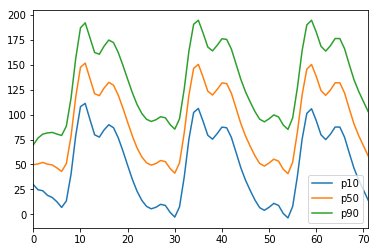

In [39]:
arima_predicts.plot()

In [40]:
# Remove the timezone
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

In [41]:

arima_predicts.sample()

,item_id,date,p10,p50,p90
40,client_12,2014-11-01 16:00:00+00:00,87.486651,131.849198,176.211745


In [42]:
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

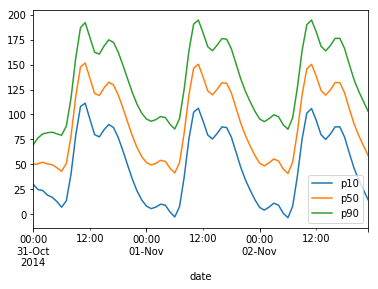

In [43]:
arima_predicts.plot()

In [44]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2014-10-31 00:00:00
2014-11-02 23:00:00


Here we can see our prediction goes from October 31st to November 2nd as expectged given our 72 hour interval forecast horizon. Also we can see the cyclical nature of the predictions over the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

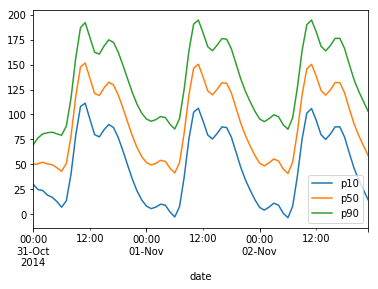

In [45]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

In [46]:
# Now strip the timezone information
arima_predicts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-10-31 00:00:00 to 2014-11-02 23:00:00
Data columns (total 3 columns):
p10    72 non-null float64
p50    72 non-null float64
p90    72 non-null float64
dtypes: float64(3)
memory usage: 2.2 KB


In [47]:
actual_df = pd.read_csv("../data/item-demand-time-validation.csv", names=['timestamp','value','item'])
actual_df.tail()

,timestamp,value,item
715,2014-11-29 19:00:00,47.263682,client_12
716,2014-11-29 20:00:00,51.616915,client_12
717,2014-11-29 21:00:00,49.129353,client_12
718,2014-11-29 22:00:00,41.666667,client_12
719,2014-11-29 23:00:00,42.703151,client_12


In [48]:
actual_df = actual_df[(actual_df['timestamp'] >= '2014-10-31') & (actual_df['timestamp'] < '2014-11-03')]

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)
                                   
validation_df = results_df.pivot(columns='source', values='value', index="timestamp")

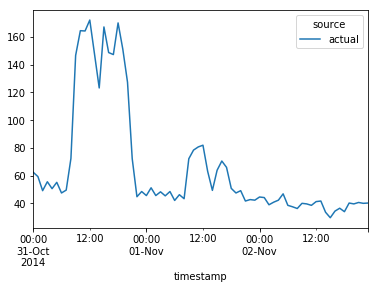

In [49]:
validation_df.plot()

In [50]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

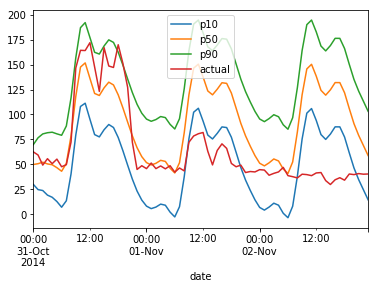

In [51]:
# Plot
arima_val_df.plot()

## Prophet Eval

In [52]:
# Prophet Eval
prophet_predicts = pd.read_csv("../data/"+prophet_filename)
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

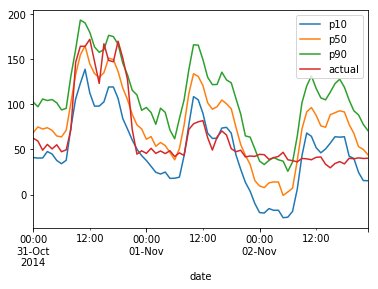

In [53]:
# Plot
prophet_val_df.plot()

## DeepAR+ Eval

In [54]:
# DeepAR+ Eval
deeparp_predicts = pd.read_csv("../data/"+deep_ar_filename)
deeparp_predicts.sample()
# Remove the timezone
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date'])
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None)
deeparp_predicts.set_index('date', inplace=True)
deeparp_predicts = deeparp_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
deeparp_val_df = deeparp_predicts.join(validation_df, how='outer')

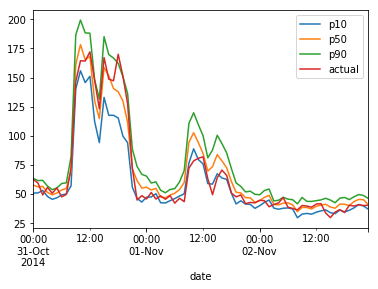

In [55]:
# Plot
deeparp_val_df.plot()

What is particularly interesting here is that we were below the actual numbers for a good portion of the day even with p90. We did see great performance from Prophet and the metrics indicate that DeepAR+ is objectively better here so now we will add related time series data to our project and see how the models behave then.

## Plotting it all together

Lastly we will take a look at our p50 prediction from ARIMA, Prophet, and DeepAR+ where the latter leverage related time series data to see how close they are over our validation period.


In [56]:
# Creating a final df
validation_df_final = validation_df.copy()
validation_df_final = validation_df_final[['actual']]
# ARIMA P50
arima_p50 = arima_predicts.copy()
arima_p50 = arima_p50[['p50']]
arima_p50.rename(columns = {'p50':'ARIMA'}, inplace = True)
# Prophet P50:
prophet_val_p50 = prophet_predicts.copy()
prophet_val_p50 = prophet_val_p50[['p50']]
prophet_val_p50.rename(columns = {'p50':'PROPHET'}, inplace = True)
# DeepAR+ P50:
deeparp_val_p50 = deeparp_predicts.copy()
deeparp_val_p50 = deeparp_val_p50[['p50']]
deeparp_val_p50.rename(columns = {'p50':'DEEPARP'}, inplace = True)
# Join DFs
validation_df_final = validation_df_final.join(arima_p50, how='outer')
validation_df_final = validation_df_final.join(prophet_val_p50, how='outer')
validation_df_final = validation_df_final.join(deeparp_val_p50, how='outer')
validation_df_final.head()


,actual,ARIMA,PROPHET,DEEPARP
timestamp,,,,
2014-10-31 00:00:00,62.396352,49.739680,68.694947,57.543697
2014-10-31 01:00:00,59.286899,50.541527,74.909936,56.000462
2014-10-31 02:00:00,49.129353,52.032893,72.633329,56.448261
2014-10-31 03:00:00,55.555556,50.317170,74.063811,51.267105
2014-10-31 04:00:00,50.580431,49.509119,71.178775,49.253185


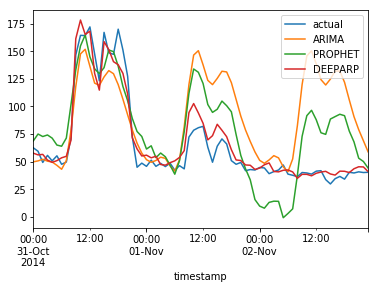

In [57]:
validation_df_final.plot()

In [58]:
boto3.Session().resource('s3').Bucket(bucket_name).Object("DeepAR/mlimday_deep_ar_algo_forecast_2020-04-16T18-12-03Z_part0.csv").delete()

{'ResponseMetadata': {'RequestId': 'EE91FA10FFCF3986',
  'HostId': 'hdhJpyyirS9CSZoYkHVb43q5Nq1Nxfho3opV0CBtyQifsb2f4faE4nrFcAVAddhlsyivMGVrfQ8=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'hdhJpyyirS9CSZoYkHVb43q5Nq1Nxfho3opV0CBtyQifsb2f4faE4nrFcAVAddhlsyivMGVrfQ8=',
   'x-amz-request-id': 'EE91FA10FFCF3986',
   'date': 'Mon, 20 Apr 2020 20:56:09 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [61]:
%store datasetGroupArn
%store target_datasetArn
%store role_name
%store bucket_name
%store region
%store ds_import_job_arn
%store prophet_forecast_arn
%store arima_forecast_arn
%store deeparp_forecast_arn
%store arima_arn
%store prophet_arn
%store deeparp_arn
%store deep_ar_filename
%store arima_filename
%store prophet_filename
%store target_datasetArn




Stored 'datasetGroupArn' (str)
Stored 'target_datasetArn' (str)
Stored 'role_name' (str)
Stored 'bucket_name' (str)
Stored 'region' (str)
Stored 'ds_import_job_arn' (str)
Stored 'prophet_forecast_arn' (str)
Stored 'arima_forecast_arn' (str)
Stored 'deeparp_forecast_arn' (str)
Stored 'arima_arn' (str)
Stored 'prophet_arn' (str)
Stored 'deeparp_arn' (str)
Stored 'deep_ar_filename' (str)
Stored 'arima_filename' (str)
Stored 'prophet_filename' (str)
Stored 'target_datasetArn' (str)
